In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import time
import utils

import os

out_root = '../../out/ARIMA-WIFI'
root = '../../dataset'
t_path = ['dataset_1790789260.csv',
          'dataset_1095394822.csv',
          'dataset_479911147.csv',
          'dataset_665254893.csv',
          
        ] 

s_path = ['dataset_320725673.csv',
          'dataset_401881001.csv',
          'dataset_1992961554.csv',
          'dataset_852552682.csv',
         ] 

l_path = ['dataset_327382690.csv',
          'dataset_395223984.csv',
          'dataset_1999618571.csv',
         ]

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 17
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size

# Outlier detection using ARIMA Forecasts

## What is an ARIMA model?

ARIMA (Auto-Regressive Integrate Moving Average) is a generalization of ARMA models which cannot be applied to non-stationary data.

An ARMA model is composed by an AutoRegressive Model (AR(p)) and a Moving Average Model (MA(q)).
In an autoregressive model the value of the series $y_t$ at time $y$ is defined as a linear combination of the values in the immediately preceding window of length $p$:
<center> $y_t = \sum\limits_{i=1}^p a_i \cdot y_{t-1} + c +\epsilon_t$ </center>
where the parameters $a_i, c$ need to be learned from the data.


In a MovingAverage model the prediction is made on the basis of the past history deviation from predicted values. The model is defined as follows:
<center> $y_t = \sum\limits_{i=1}^q b_i \cdot \epsilon_{t-1} + c +\epsilon_t$ </center>
The parameter $c$ is the mean of the time series, the value $\epsilon_t$ are assumed to be white noise error terms uncorrelated with one another.

So an ARMA Model is expressed as:
<center> $y_t = \sum\limits_{i=1}^p a_i \cdot y_{t-1} + \sum\limits_{i=1}^q b_i \cdot \epsilon_{t-1} + c +\epsilon_t$ </center>

As said, the ARMA model is not able to addess non-stationary data. So in many cases the non-stationary data can be addressed by combining differencing with the ARMA model, resulting in a ARIMA model.

Differentiation is used for converting time series to stationary forms, so the value $y_t$ is replaced by the difference of it and the previous value

<center>$y'_t = y_t - y_{t-1}$</center>

Can be used many order of differentiation in order to gain stationarity in the data.

Thus adding differentiation to ARMA model we gain the ARIMA model that can be expressed as:
<center> $y'_t = \sum\limits_{i=1}^p a_i \cdot y'_{t-1} + \sum\limits_{i=1}^q b_i \cdot \epsilon_{t-1} + c +\epsilon_t$ </center>

This one in particular is an ARIMA model with order of differencing d = 1.

## Forecasting with ARIMA

Here we use an ARIMA model to predict the future values, then compare the prediction with the new point, and if the difference is above certain threshold (depending on type of sensor) we mark the point as an outlier.

We will rely on the auto_arima function to find the best order of the ARIMA parameters.


In this first experiment, we take one dataset we split it into train and test.
We fit a model, then try to make prediction on the test set.

In [3]:
from pmdarima import auto_arima

path = os.path.join(root, t_path[0])
df = pd.read_csv(path, header = None)
x = 19817
df = df[:x]
t_x = int(x*0.7)
df_train = df[:t_x]
df_test = df[t_x:]

df_train = df_train.set_index(1)
df_train = df_train[2]

df_test = df_test.set_index(1)
df_test = df_test[2]

model = auto_arima(df_train, start_p=0, start_q=0, error_action="ignore", suppress_warnings=True)

<IPython.core.display.Javascript object>


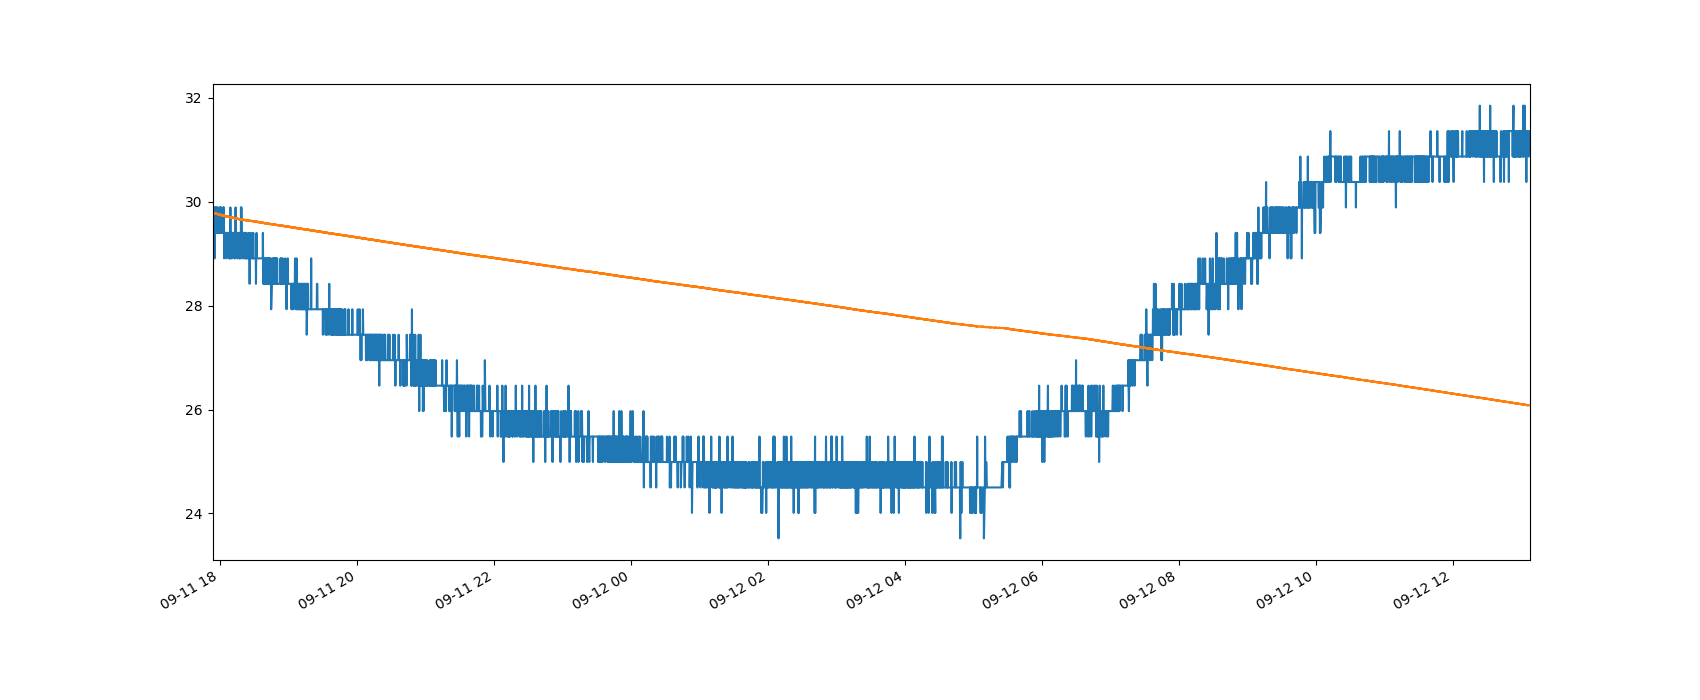

In [4]:
preds = model.predict(n_periods = len(df_test), return_conf_int=False)

df_test.index =  df_test.index.values.astype('datetime64[ms]')
fig, ax = plt.subplots()
df_test.plot(ax=ax, kind = 'line')

x = df_test.index.values.astype('datetime64[ms]')
y = preds
ax.plot(x, y)
ax.xaxis_date()

In the plot the blue line are the measurement performed by the sensor, while the orange line are the prediction.
The prediction made this way is useless for the purpose.

Probably the mistake is not considering the new values arrived to fix the prediction. 

So next step we will try to make prediction considering also the new values arriving using a window of 1 hour (around 360 measurements) to update the parameters.

In [5]:
df_test = df[t_x:]
gen = utils.windows_generator(df_test, np.timedelta64(60,'m'), 1)

preds = []

for start, end, window in gen:
    if (len(window) == 0):
        continue
        
    win_pred = model.predict(n_periods = len(window), return_conf_int=False)
    preds += list(win_pred)
    
    window = window.set_index(1)
    window = window[2]
    
    model.add_new_observations(window) # but do not update the model

<IPython.core.display.Javascript object>


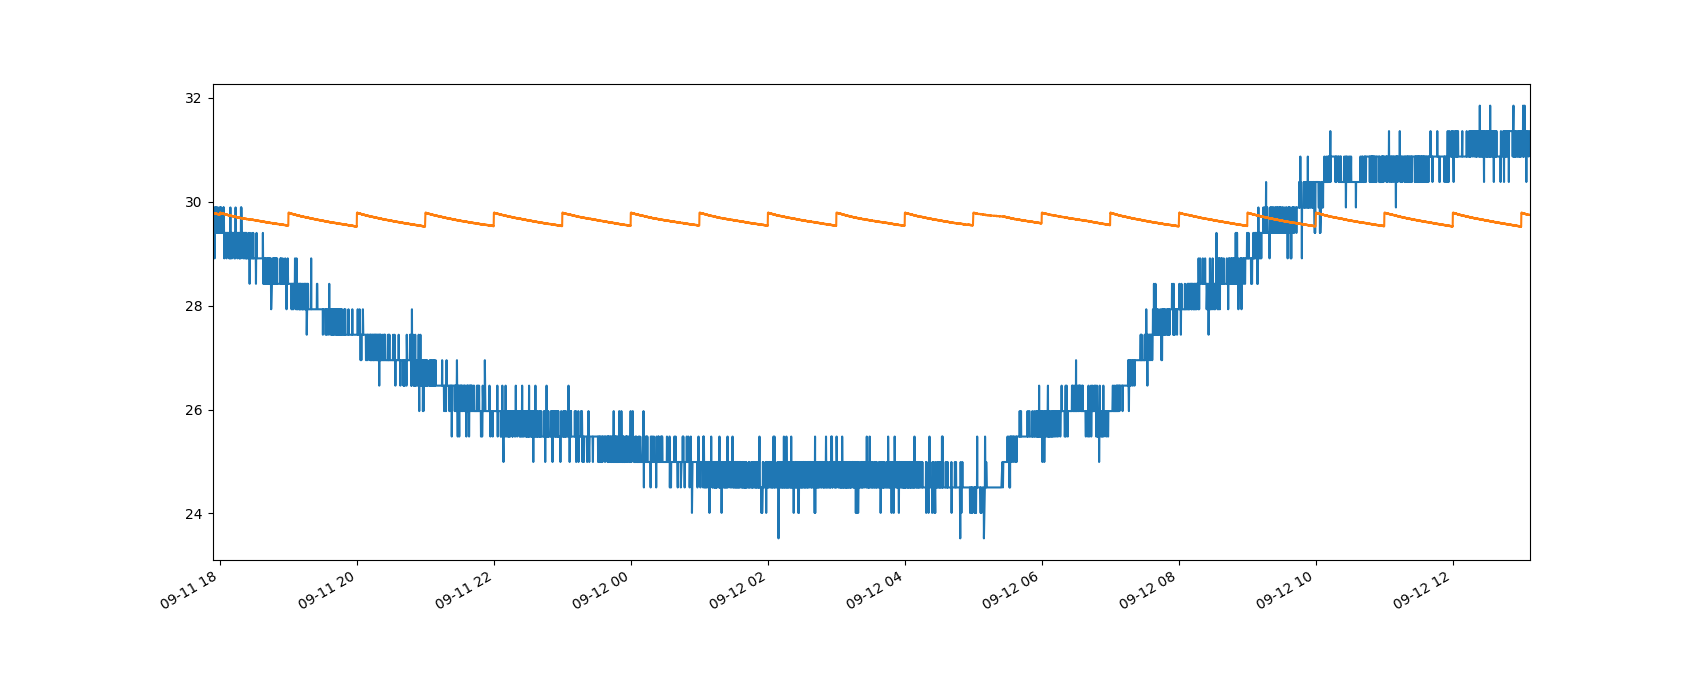

In [6]:
df_test = df_test.set_index(1)
df_test = df_test[2]
df_test.index =  df_test.index.values.astype('datetime64[ms]')

fig, ax = plt.subplots()
df_test.plot(ax=ax, kind = 'line')

x = df_test.index.values
y = preds
ax.plot(x, y)
ax.xaxis_date()

The prediction cannot be used.

A solution is to re-train from scratch the model every time window, in this way the predictions are closer to the real values and so can be used to perform our task.

So for each time window we will produce forecast in order to classify the arriving data.
At the end of a time window we use the new data arrived to train a new model that will be used to make prediction for the next time window.

In [7]:
def ARIMA_slider(df, mins = 60, val_index = 2, ts_index = 1, tr_secs = 10):
    delta = np.timedelta64(mins,'m')
    tr = np.timedelta64(tr_secs, 's')
    expected_num_measurements = int(delta / tr)
    
    point_col = ['id', 'ts', 'val', 'pred']
    point_ret = pd.DataFrame(columns = point_col)
    
    gen = utils.windows_generator(df, delta, ts_index)
    
    name = df.iloc[0,0]
    prev_window = pd.DataFrame()
    
    for start, end, window in gen:
    
        if len(window) == 0:
            continue
            
        #we have enough data?
        if len(prev_window) < expected_num_measurements:
            prev_window = prev_window.append(window) 
        
        win_values = prev_window
        win_values = prev_window.set_index(ts_index)
        win_values = win_values[val_index]
        
        model = auto_arima(win_values, start_p=0, start_q=0, error_action="ignore", suppress_warnings=True)

        # predict next values 
        preds = model.predict(n_periods = int(expected_num_measurements), return_conf_int=False)

        for i in range(len(window)):
            frame = window.iloc[i,:]
            ts = frame[ts_index].astype('datetime64[ms]')
            value = frame[val_index]
            
            predicted = preds[i]
                        
            prev_window = prev_window.append(frame)
            prev_window = prev_window.iloc[1:,:]
                
            new_data = pd.DataFrame([[name, ts, value, predicted]], columns = point_col)
            point_ret = point_ret.append(new_data, sort = False)
                      
    return point_ret

In [8]:
def determine_outliers(df, th, tr = 10, mins = 60):
    delta = np.timedelta64(mins,'m')
    tr = np.timedelta64(tr, 's')
    expected_num_measurements = int(delta / tr)
    
    out_col = ['id', 'ts', 'val', 'pred', 'is_in']
    win_col = ['id', 'start', 'stop', '#out', '#in', '#miss']
    
    win_ret = pd.DataFrame(columns = win_col)
    out_ret = pd.DataFrame(columns = out_col)
        
    gen = utils.windows_generator(df, delta, 1)
    for start, end, window in gen:
        if len(window) == 0:
            continue
        
        n_in = 0
        n_out = 0
        
        for name, ts, value, prediction in window.values:
            
            e = abs(value-prediction)
            
            if e <= th:
                is_in = 1
                n_in += 1
            
            else:
                is_in = -1
                n_out += 1
            
            new_data = pd.DataFrame([[name, ts, value, prediction, is_in]], columns = out_col)
            out_ret = out_ret.append(new_data, sort = False)
        
        
        win_data = pd.DataFrame([[name, start, end, n_out, n_in, abs(expected_num_measurements-n_in-n_out)]], columns = win_col)
        win_ret = win_ret.append(win_data, sort = False)
    
    return out_ret, win_ret

In [9]:
def produce_plots(root, out_root, to_plot, th):
    path = os.path.join(root, to_plot)
    
    tmp_path = os.path.join(out_root, "tmp_" + to_plot)
    window_path = os.path.join(out_root, "win_" + to_plot)
    out_path = os.path.join(out_root, "out_" + to_plot)
    
    df = pd.read_csv(path, header=None)
    
    name = df.iloc[0,0].split('/')
    name = name[-2]+'/'+name[-1]
    
    try:
        y = pd.read_csv(window_path)
        y = y.astype({'start': 'datetime64[ms]', 'stop': 'datetime64[ms]'})
        x = pd.read_csv(out_path)
        x = x.astype({'ts': 'datetime64[ms]'})
    except Exception as e:
        print(e)
        try:
            tmp = pd.read_csv(tmp_path)
        except Exception as e:
            print(e)
            tmp = ARIMA_slider(df)
            tmp.to_csv(tmp_path, index = None)
    
        tmp = tmp.astype({'ts': 'datetime64[ms]'})
        tmp = tmp.astype({'ts': 'int64'})
        tmp['ts'] = tmp['ts']//1e6
        tmp = tmp.astype({'ts': 'int64'})

        x, y = determine_outliers(tmp, th)
        y.to_csv(window_path, index = None)
        x.to_csv(out_path, index= None)
    
    fig, ax = plt.subplots(nrows = 1, ncols = 2)
    fig.tight_layout()
    fig.autofmt_xdate()
    fig.subplots_adjust(left = 0.05, bottom=0.3)
    
    x.plot(ax = ax[0], x = 1, y = [2,3], kind='line', title = name)
    for l in x.values:
        ts = l[1]
        val = l[2]
        boolean = l[4]
        if boolean == -1:
            ax[0].plot(ts, val, 'ro-')
    ax[0].xaxis_date()

    y.plot(x = 1, y = [3,4,5], ax = ax[1], kind = 'bar', stacked = 'True', colormap = 'summer', title = name)

    ax[1].set_xlabel('window start time')
    ax[1].set_ylabel('#number of measurements')
    ax[1].xaxis_date()
    ax[1].legend()
    ax[1].grid()
    
    num_out = y.iloc[:,3].values.sum()
    num_in = y.iloc[:,4].values.sum()
    num_missed = y.iloc[:,5].values.sum()
    
    return name, num_out, num_in, num_missed

In [10]:
if not os.path.isdir(out_root):
    os.mkdir(out_root)
    
res = []

# Temp Sensors

Now the prediction are made on a hourly basis, re-training the model at the end of the window.

In order to detect outliers we need to set a threshold to use. 
Usually the measurements within a time window are at most 0.5-1 degree of difference, so as threshold we use 0.5.

<IPython.core.display.Javascript object>


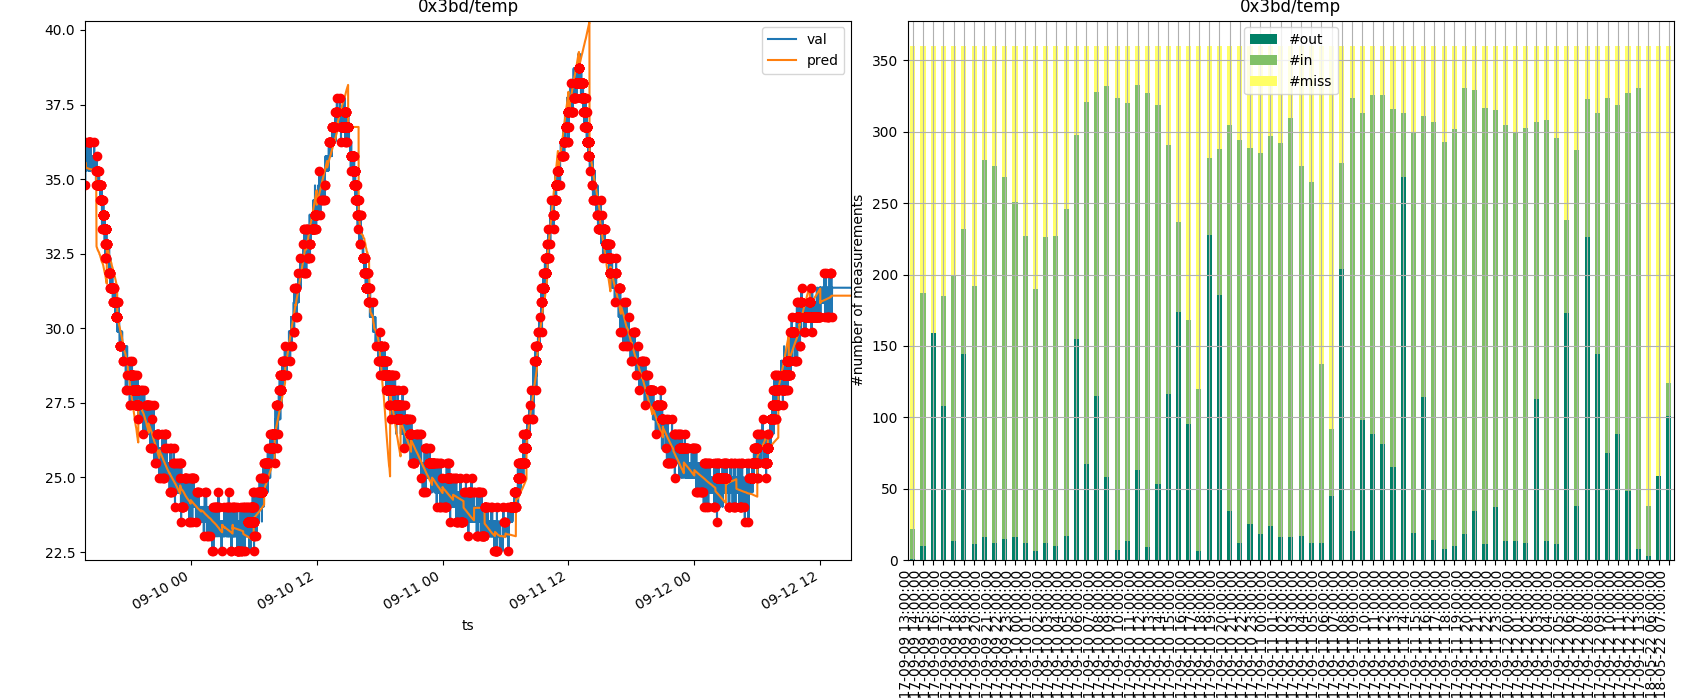

<IPython.core.display.Javascript object>


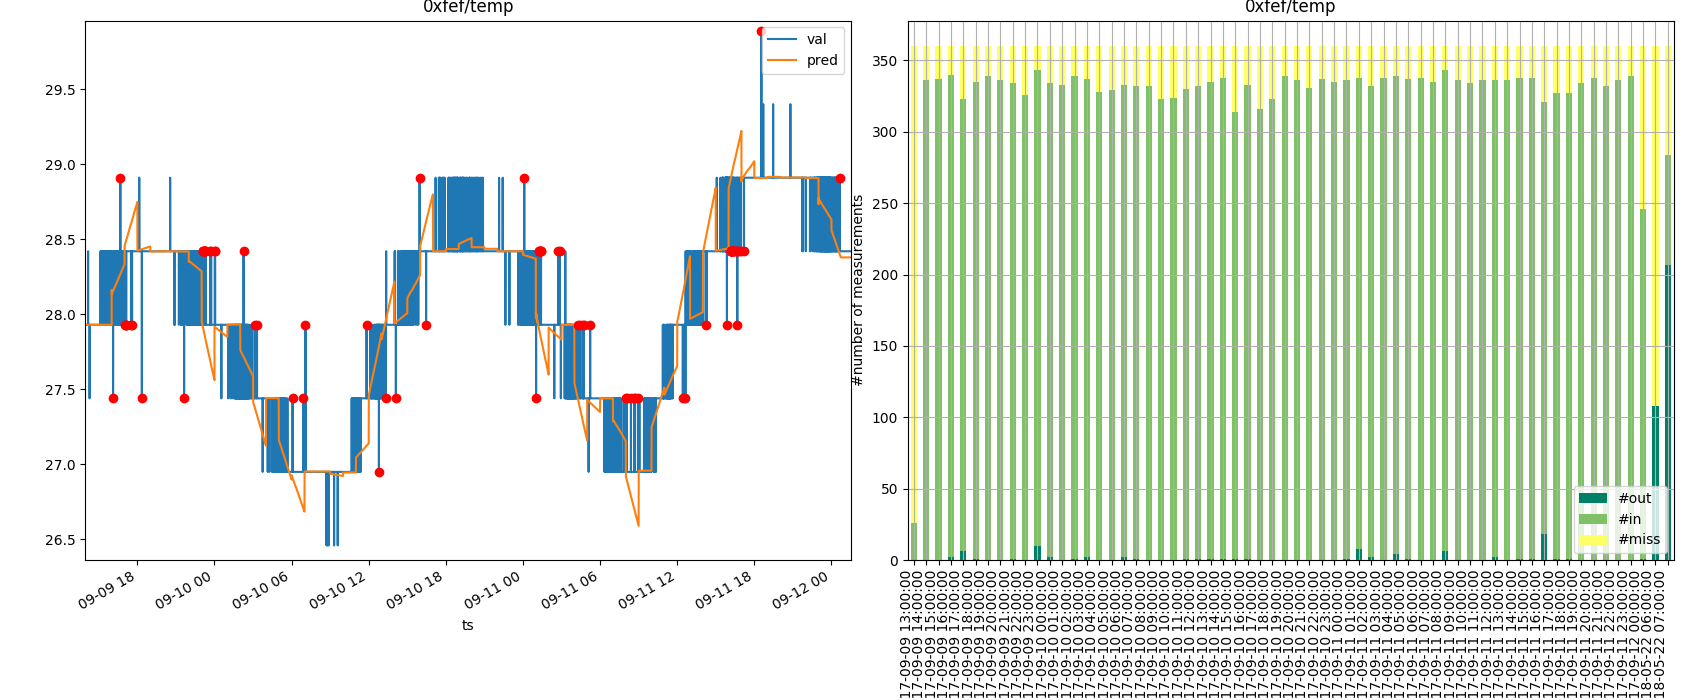

<IPython.core.display.Javascript object>


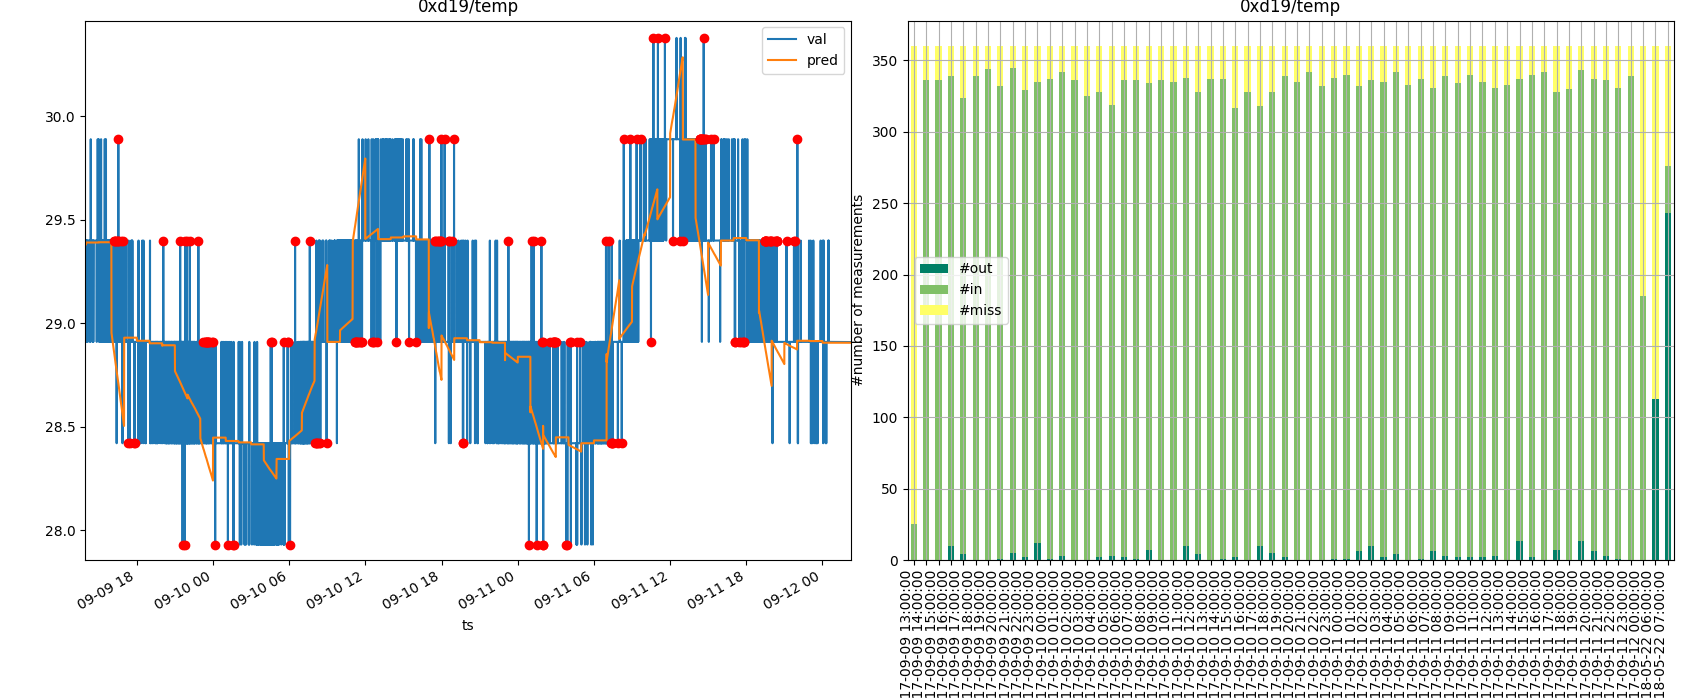

<IPython.core.display.Javascript object>


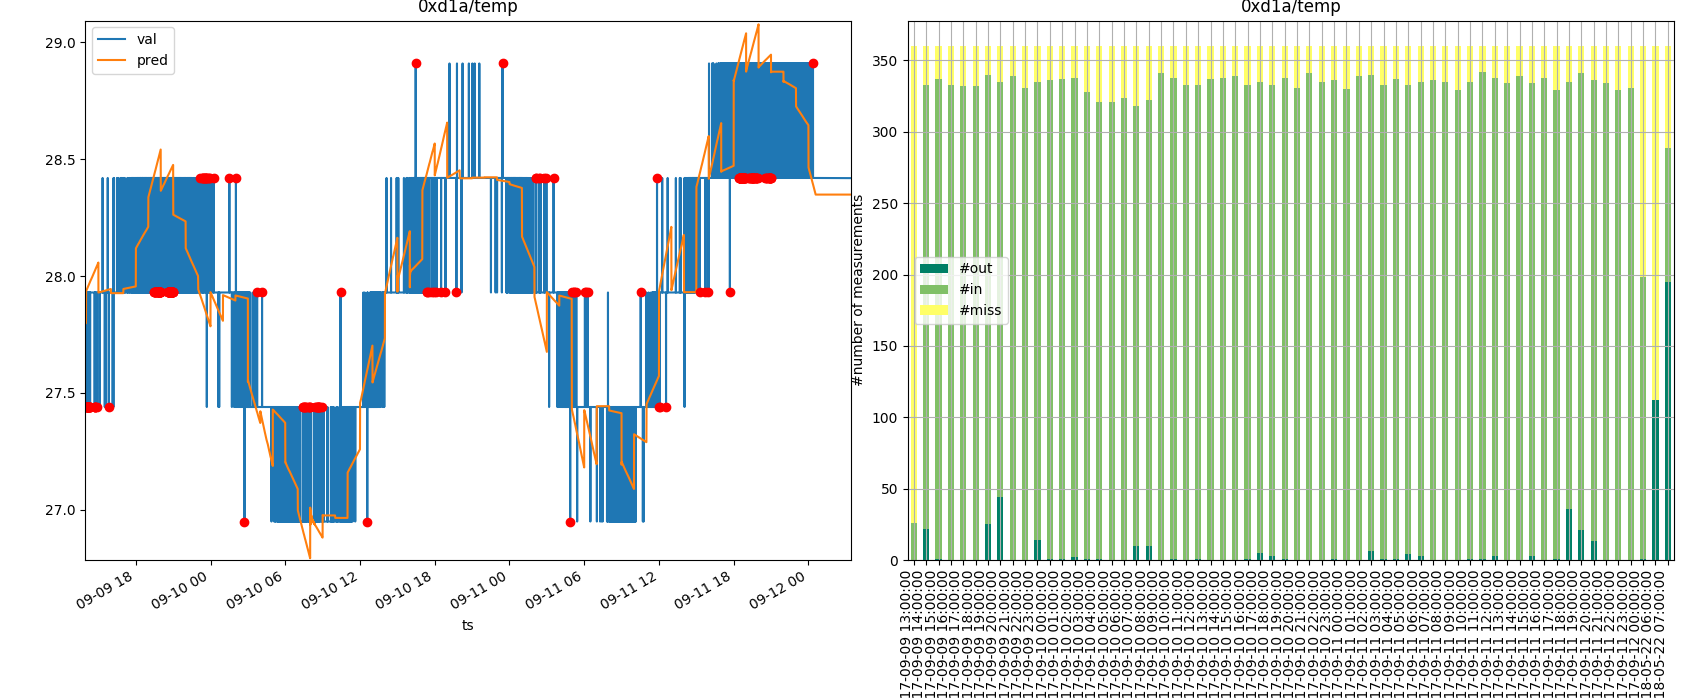

In [11]:
thresh = 0.5
for x in t_path:
    name, num_out, num_in, num_missed = produce_plots(root, out_root, x, thresh)
    res.append("|" + str(name) + "|" + str(num_out) + "|" + str(num_in) + "|" + str(num_missed) + "|" + str(num_out*100/(num_out+num_in)) + "|")

The prediction follows in most of the cases the shape of the measurements, so re-fit the model every hour allow us to use the prediction in order to detect outliers.

For all the sensors (except the one in 0x3bd) in most of the cases the outliers found are the abnormal peak in the stream. 
For sensor in 0x3bd the values of the measurements vary a lot during the same day, so the prediction will drop or grow faster after certain time window, deviating a lot from the real value of the data, marking a lot of measurements as outliers.

## Light sensors

In this case, the values of the sensor are all between 0-200 and the values effectively assumed are only 5 (0, 12, 33, 75, 200).
The threshold chosen is 70.

<IPython.core.display.Javascript object>


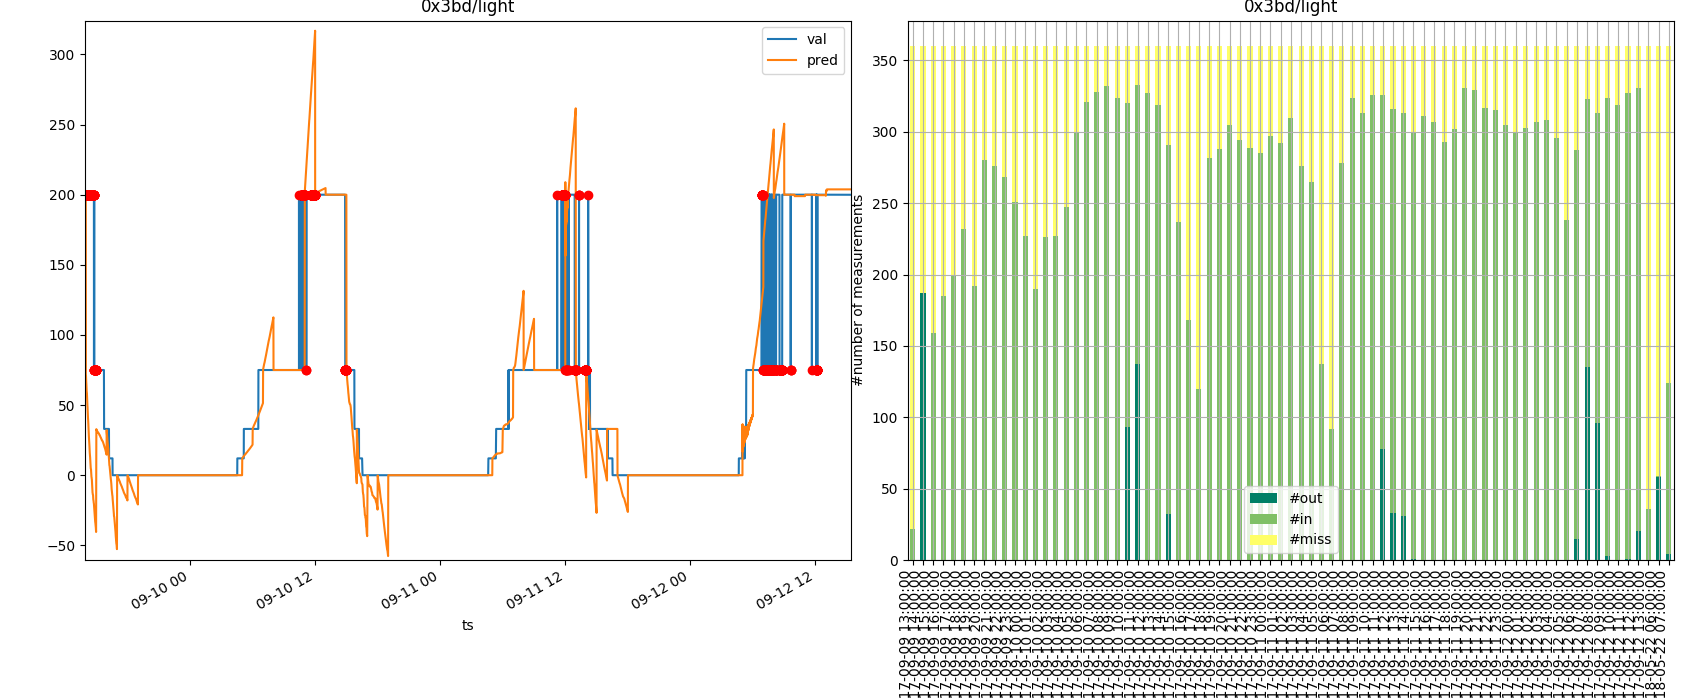

<IPython.core.display.Javascript object>


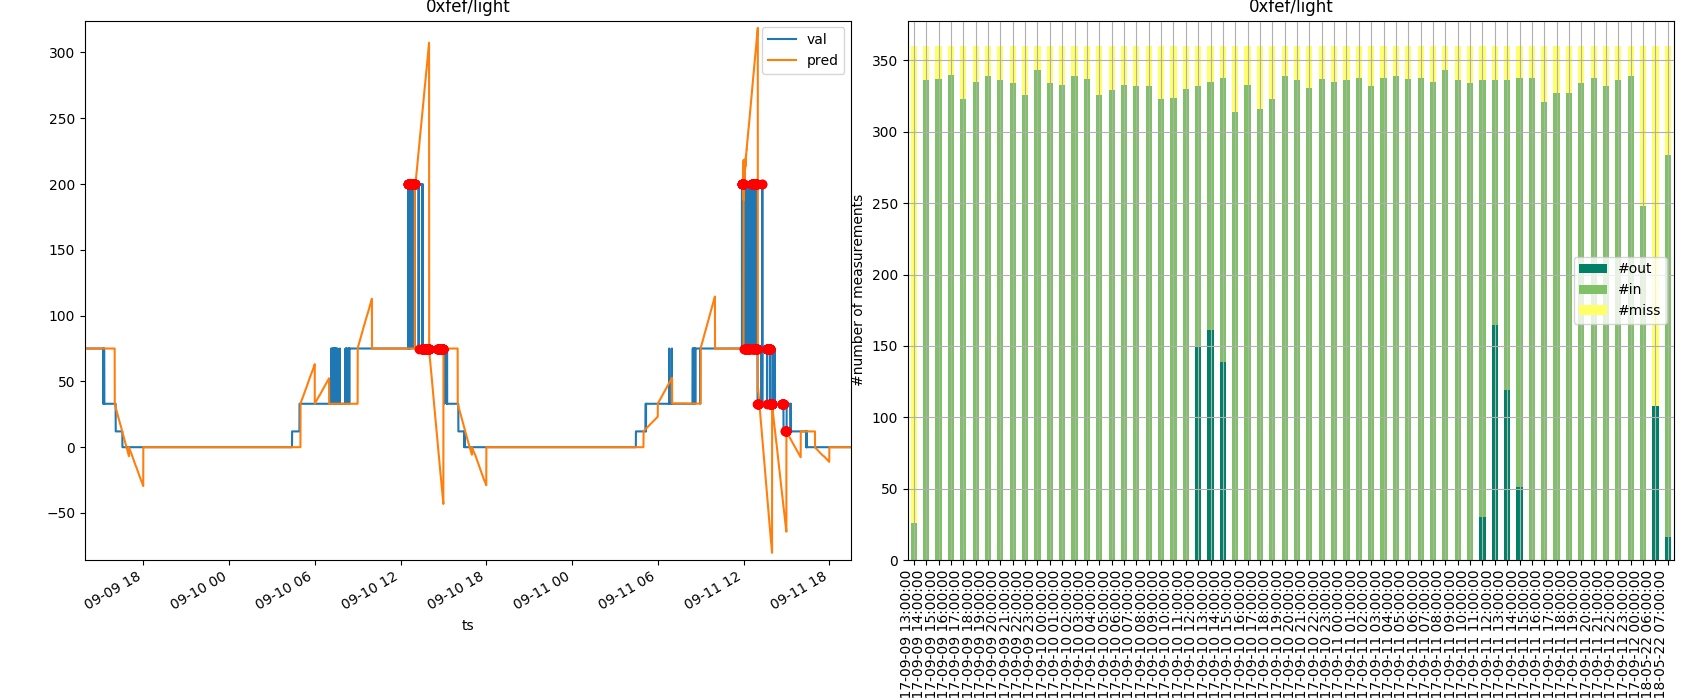

<IPython.core.display.Javascript object>


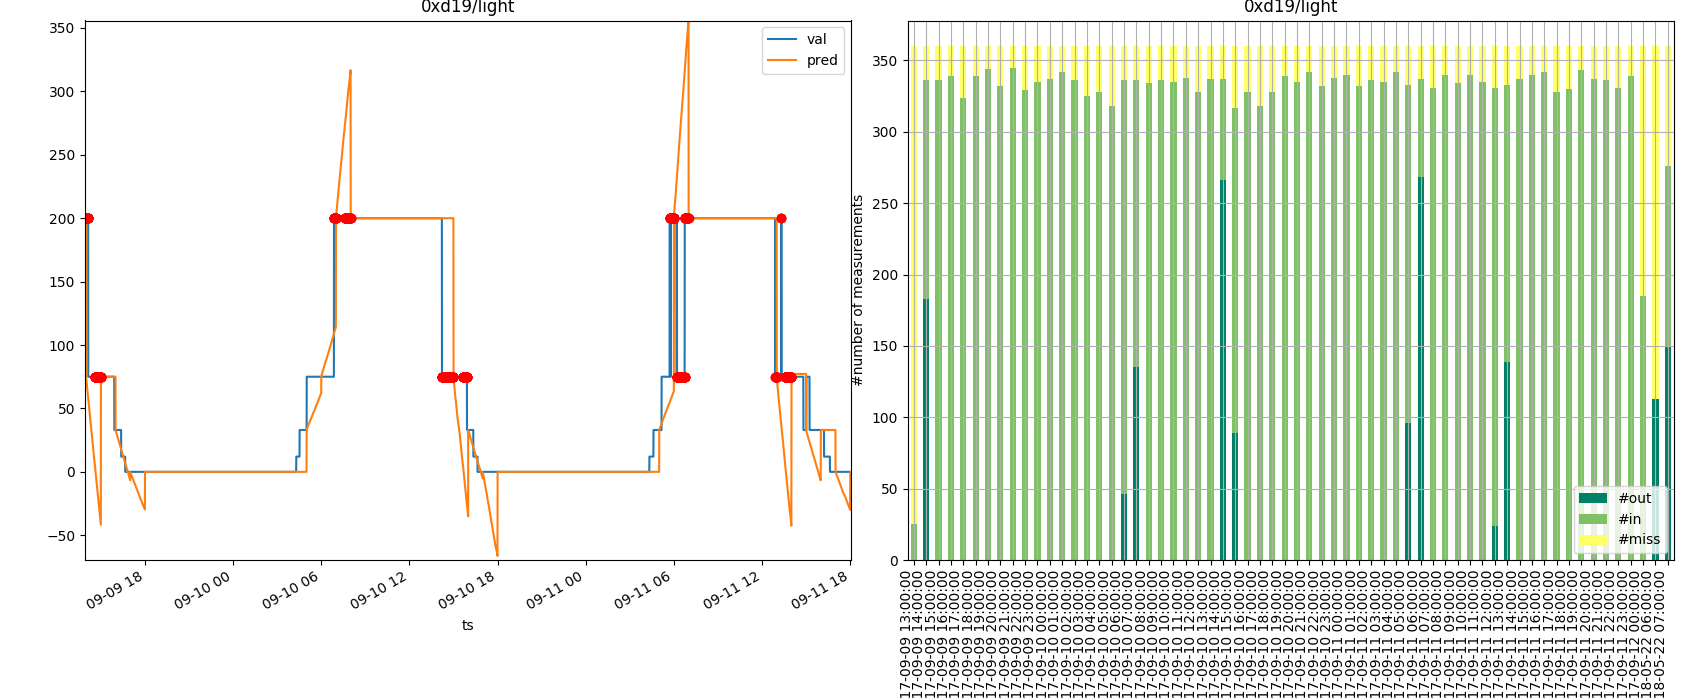

In [12]:
thresh = 70
for x in l_path:
    name, num_out, num_in, num_missed = produce_plots(root, out_root, x, thresh)
    res.append("|" + str(name) + "|" + str(num_out) + "|" + str(num_in) + "|" + str(num_missed) + "|" + str(num_out*100/(num_out+num_in)) + "|")

The time series generated by the sensor is mostly constant.
So when there is a step the prediction will increase or decrease too fast diverging a lot from the time series, this will generate a lot of outliers for certain time windows.

## Sound Sensors

In this case for the majority of sensors the values are almost constant, so using a too high threshold doesn't seem a good idea.

Node 0x3bd shows measurements between 30-100 while the others do not go outside the range 37-41.

So is chosen a threshold of 0.7, assuming the sensor in 0x3bd is behaving in an anomalous way.

<IPython.core.display.Javascript object>


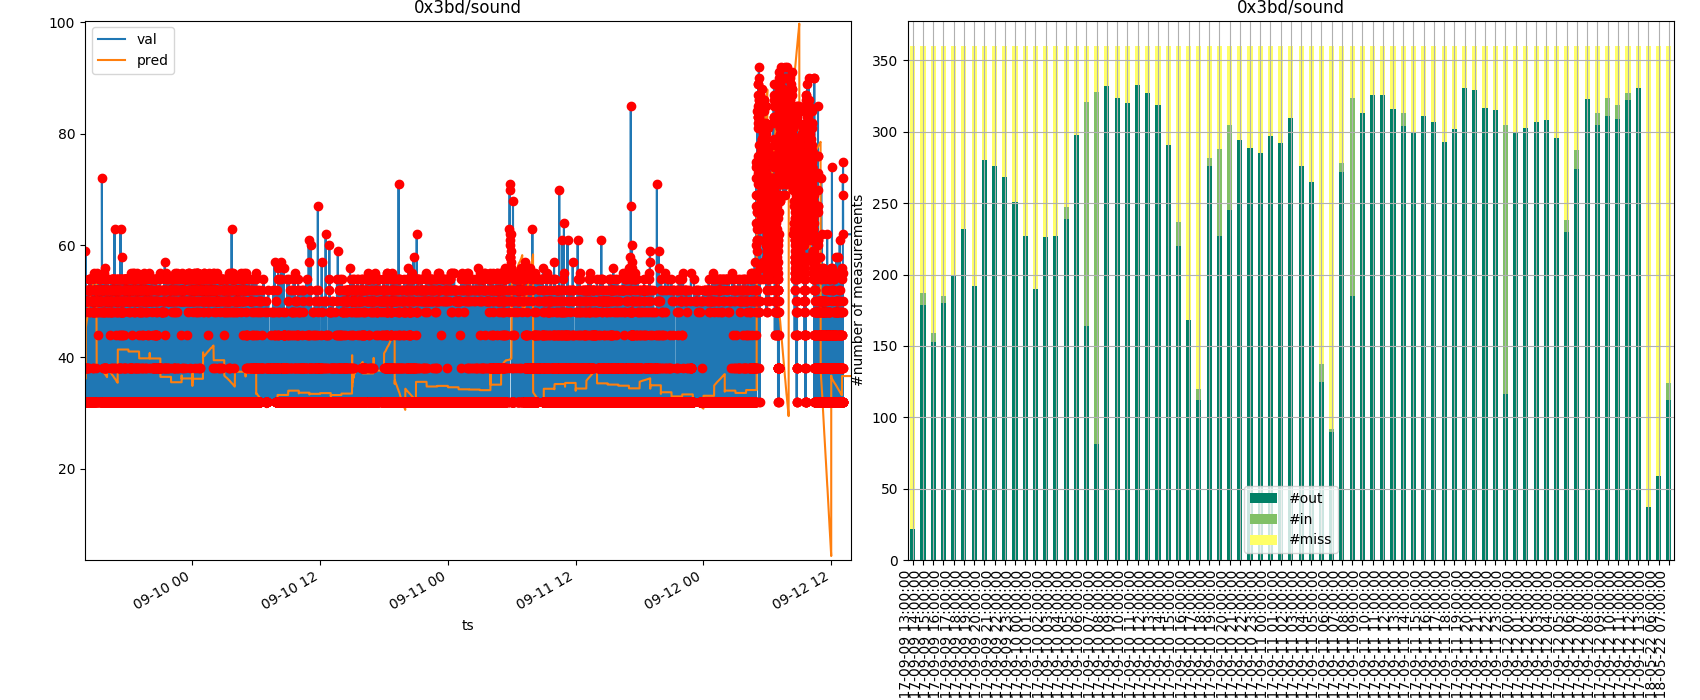

<IPython.core.display.Javascript object>


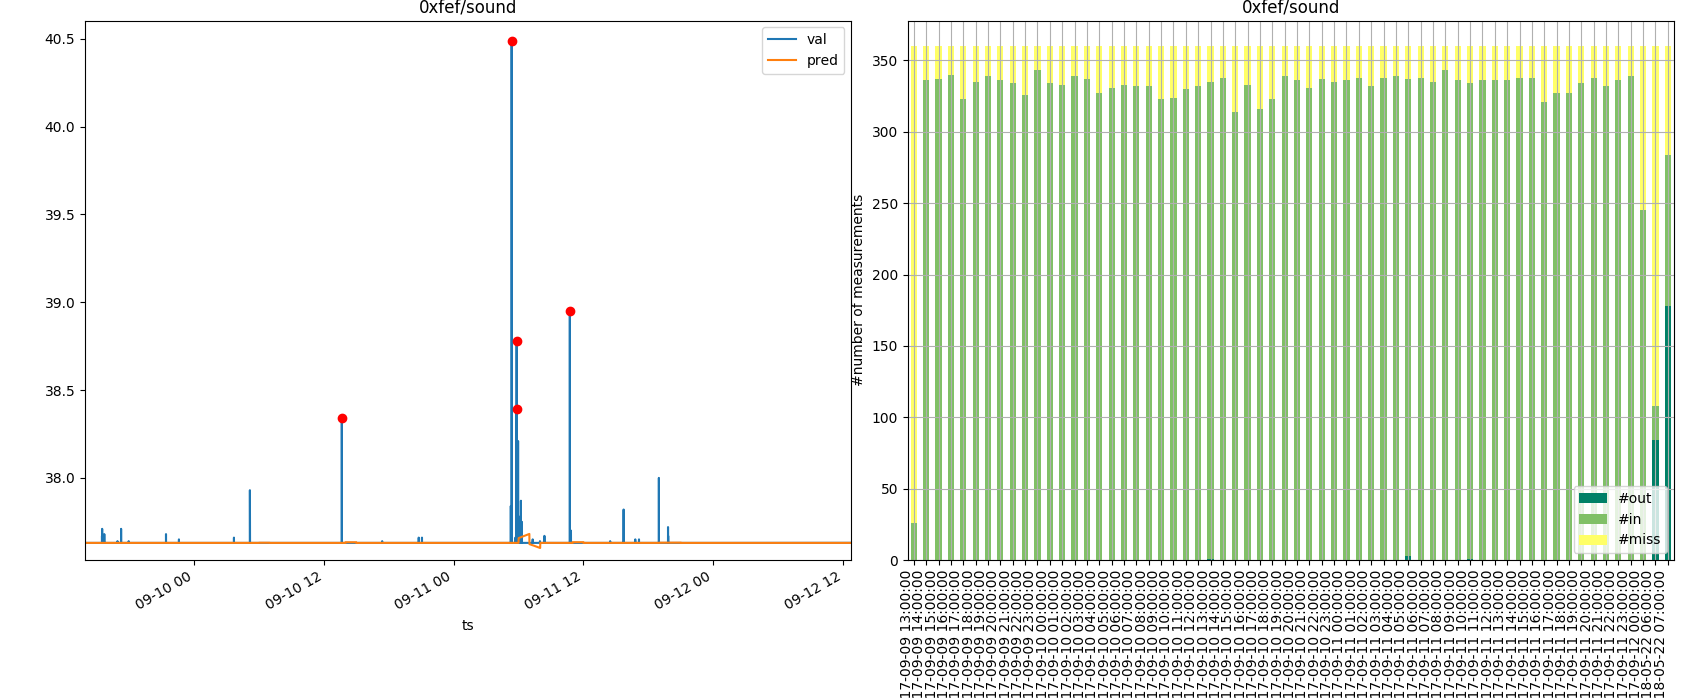

<IPython.core.display.Javascript object>


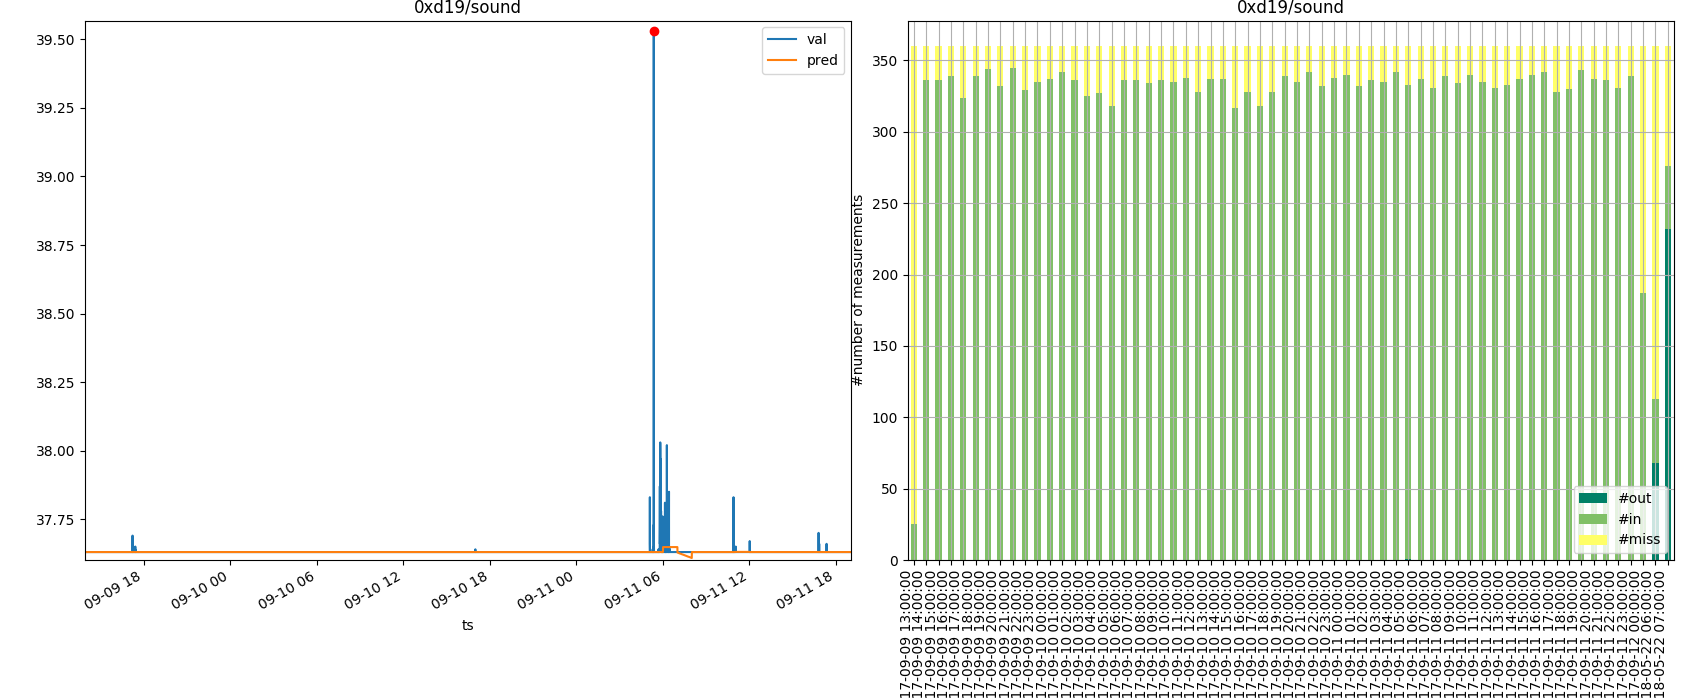

<IPython.core.display.Javascript object>


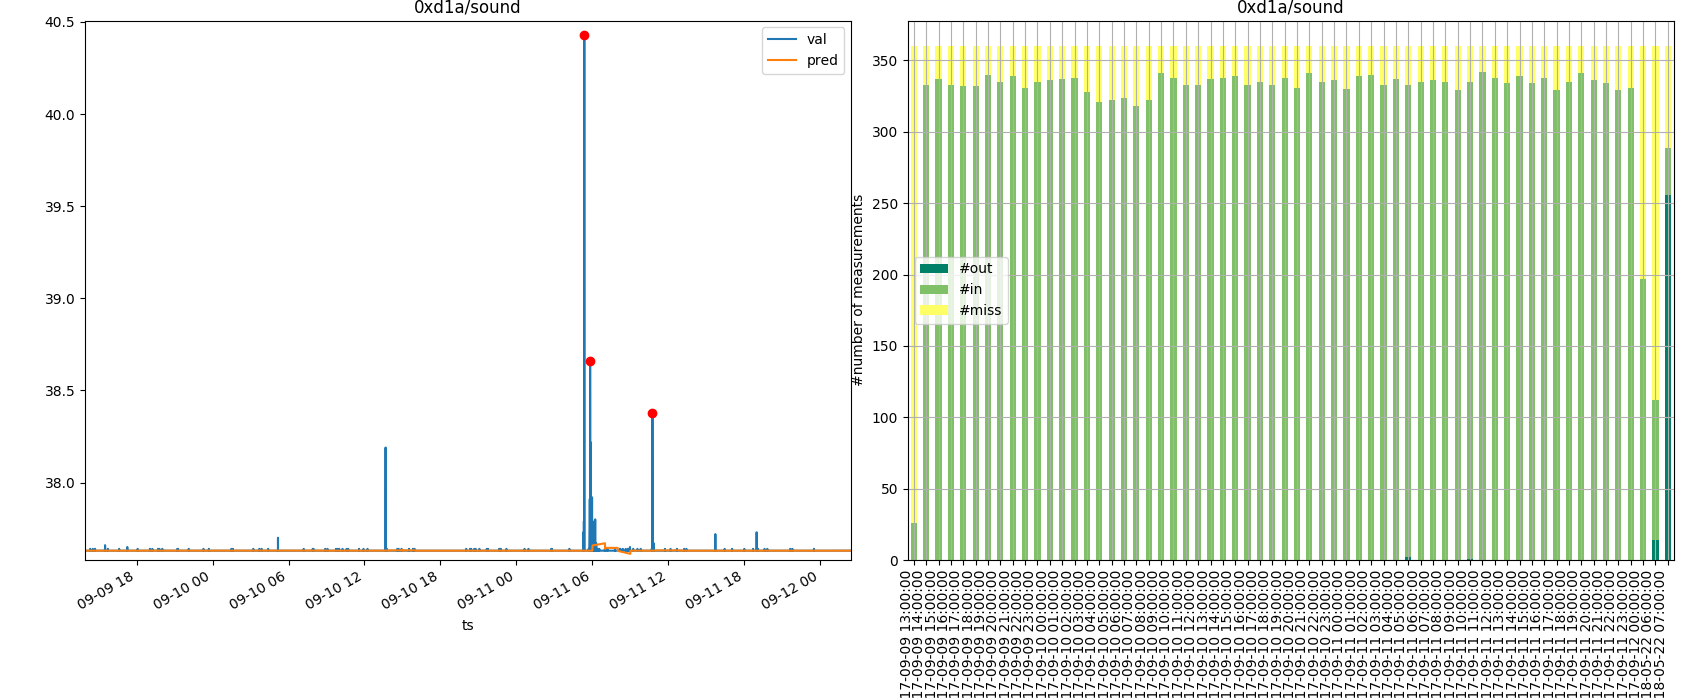

In [13]:
thresh = 0.7
for x in s_path:
    name, num_out, num_in, num_missed = produce_plots(root, out_root, x, thresh)
    res.append("|" + str(name) + "|" + str(num_out) + "|" + str(num_in) + "|" + str(num_missed) + "|" + str(num_out*100/(num_out+num_in)) + "|")

Except for node 0x3bd the stream is almost constant, so the prediction is constant except for 09-11 where the sensors register some peaks, but the prediction didn't change significatively from the past.

The node in 0x3bd show a really noisy behavior, so the distance between measurement and prediction are in most of the cases above the threshold.

print("|sensor|#outliers|#inliers|#missing|%outliers|\n|---|---|---|---|---|")
for val in res:
    print(val)

## Results over 1 hour aggregation
|sensor|#outliers|#inliers|#missing|%outliers|
|---|---|---|---|---|
|0x3bd/temp|4365|15635|7000|21.825|
|0xfef/temp|396|19604|2320|1.98|
|0xd19/temp|531|19469|2320|2.655|
|0xd1a/temp|547|19453|2320|2.735|
|0x3bd/light|924|19076|7000|4.62|
|0xfef/light|939|19061|2320|4.695|
|0xd19/light|1509|18491|2320|7.545|
|0x3bd/sound|18991|1009|7000|94.955|
|0xfef/sound|267|19733|2320|1.335|
|0xd19/sound|301|19699|2320|1.505|
|0xd1a/sound|273|19727|2320|1.365|